<a href="https://colab.research.google.com/github/mehrnazeraeisi/Hill-Valley-with-Noise-1046/blob/main/Hill_Valley_with_Noise_1046_KnnClassification_Modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

In [3]:
# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)


In [4]:
!pip install openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.2 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=ffe907b2bd032c59b5bae81df3ad30b1f6729fa34f2d3d9eeeed6c711c909d08
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [5]:
# Hill-Valley with Noise
# تشخیص سیگنال بالا یا پایین

import openml
import pandas as pd

dataset = openml.datasets.get_dataset(1046)
data, y_data, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# 🔧 افزودن target به dataframe کامل (مثل خواندن فایل CSV)
data['rating'] = y_data  # فرض می‌گیریم نام ستون هدف "rating" باشه برای یکسان بودن با مثال شما

print(data.shape)
# حذف سطرهای حاوی NaN
data = data.dropna()

# 🔍 نمایش اطلاعات
print(data.columns)
print(data.head())
print(data.shape)

# 🎯 جدا کردن ویژگی‌ها و برچسب‌ها (مطابق ساختار شما)
X_data = data.drop('rating', axis=1)
y_data = data['rating']
data_features = X_data.columns


(15545, 6)
Index(['id', 'start', 'end', 'event', 'size', 'rating'], dtype='object')
    id      start        end  event  size rating
0  1.0        0.0   913439.0      0  14.0      0
1  1.0   913439.0  1292405.0      1  14.0      0
2  1.0  1292405.0  1540749.0      0  14.0      1
3  2.0        0.0    50170.0      0  14.0      0
4  3.0        0.0   913439.0      0  18.0      0
(15545, 6)


In [6]:
# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, data_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)


🔎 Feature-wise Accuracy Ranking:
  Feature  Accuracy
1   start  0.956320
2     end  0.835510
0      id  0.780058
4    size  0.677067
3   event  0.328594


In [7]:
# [5] Group features based on accuracy thresholds
strong_features = feature_scores[feature_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.83]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.78]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.67]['Feature'].tolist()


In [8]:
# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [list(data_features), strong_features, medium_features_1, medium_features_2, medium_features_3]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['all_features', 'strong_features', 'medium_features_1', 'medium_features_2', 'medium_features_3'],
    'Accuracy': acc_scores})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)


📊 Grouped Feature Performance Summary:
       Feature Group  Accuracy
0       all_features  0.944291
1    strong_features  0.956320
2  medium_features_1  0.943712
3  medium_features_2  0.943454
4  medium_features_3  0.944291


In [9]:
# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, strong_features,  data_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "strong_features": []
    }

    feature_groups = {
        "all_features": data_features,
        "strong_features": strong_features,
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(10, 5))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

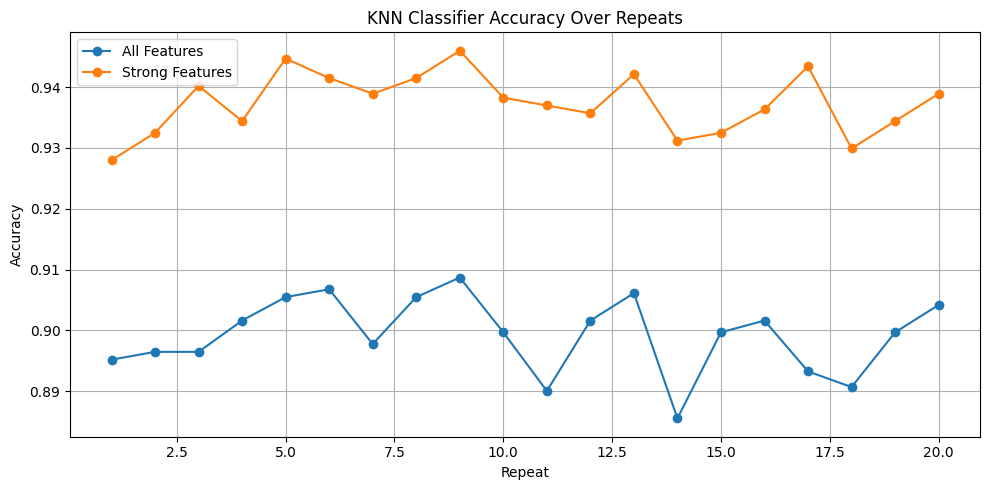

In [10]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, strong_features,  data_features, test_size=0.10, n_repeats=20)



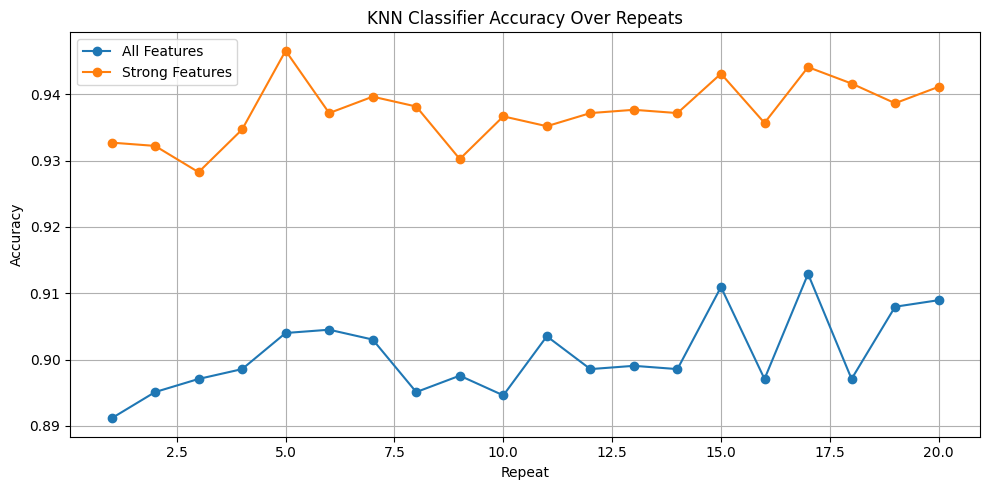

In [11]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, strong_features,  data_features, test_size=0.13, n_repeats=20)


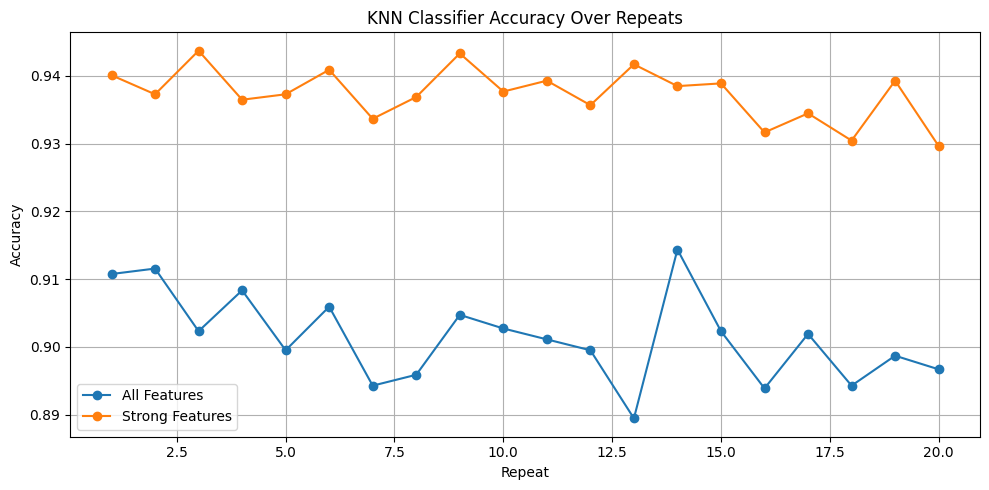

In [12]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, strong_features, data_features, test_size=0.16, n_repeats=20)


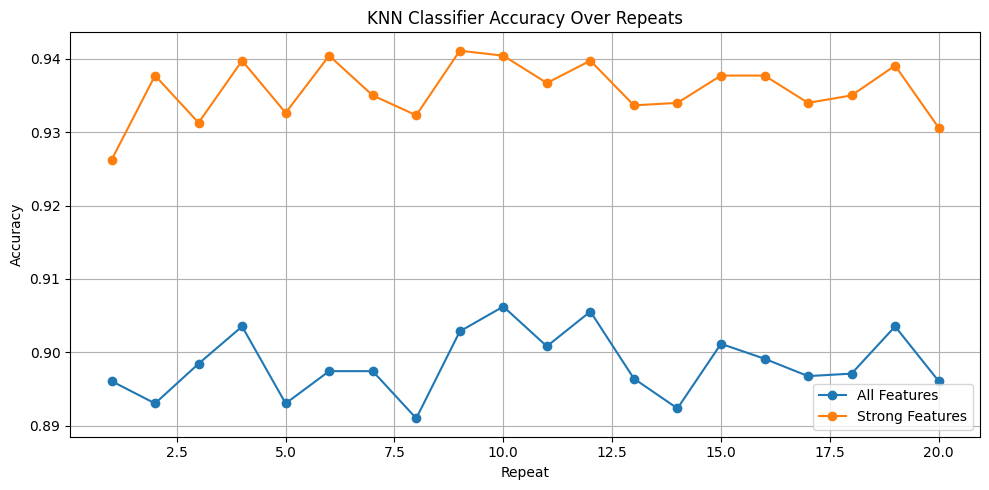

In [13]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, strong_features, data_features, test_size=0.19, n_repeats=20)


In [15]:
def build_accuracy_table(X_data, y_data, strong_features, data_features, test_sizes, n_repeats):
    results = []

    for test_size in test_sizes:
        for i in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

            # KNN for all features
            k_all = int(np.sqrt(len(X_train)))
            knn_all = KNeighborsClassifier(n_neighbors=k_all)
            knn_all.fit(X_train[data_features], y_train)
            y_pred_all = knn_all.predict(X_test[data_features])
            acc_all = accuracy_score(y_test, y_pred_all)

            # KNN for medium features
            k_modified = int(np.sqrt(len(X_train)))
            knn_modified  = KNeighborsClassifier(n_neighbors=k_modified )
            knn_modified .fit(X_train[strong_features], y_train)
            y_pred_modified  = knn_modified .predict(X_test[strong_features])
            acc_modified  = accuracy_score(y_test, y_pred_modified )

            results.append({
                "Percentage": f"{int(test_size * 100)}%",
                "Repetition": f"n={i}",
                "Accuracy (All Features)": acc_all,
                "Accuracy (Modified  KNN)": acc_modified
            })

    df_result = pd.DataFrame(results)
    return df_result

test_sizes = [0.10 , 0.13, 0.16 , 0.19 , 0.25]  # یا چند درصد دیگر مثل [0.10, 0.15, 0.25]
n_repeats = 20

accuracy_table = build_accuracy_table(X_data, y_data, strong_features, data_features, test_sizes, n_repeats)
print("\n📋 Accuracy Evaluation Table:")
print(accuracy_table)



📋 Accuracy Evaluation Table:
   Percentage Repetition  Accuracy (All Features)  Accuracy (Modified  KNN)
0         10%        n=1                 0.906752                  0.942122
1         10%        n=2                 0.899035                  0.936977
2         10%        n=3                 0.887460                  0.936334
3         10%        n=4                 0.898392                  0.942122
4         10%        n=5                 0.893248                  0.940193
..        ...        ...                      ...                       ...
95        25%       n=16                 0.894520                  0.933882
96        25%       n=17                 0.897093                  0.934397
97        25%       n=18                 0.905583                  0.936969
98        25%       n=19                 0.896321                  0.936969
99        25%       n=20                 0.891433                  0.926679

[100 rows x 4 columns]


(15545, 6)
Index(['id', 'start', 'end', 'event', 'size', 'rating'], dtype='object')
    id      start        end  event  size rating
0  1.0        0.0   913439.0      0  14.0      0
1  1.0   913439.0  1292405.0      1  14.0      0
2  1.0  1292405.0  1540749.0      0  14.0      1
3  2.0        0.0    50170.0      0  14.0      0
4  3.0        0.0   913439.0      0  18.0      0
(15545, 6)
🔎 Feature-wise Accuracy Ranking:
  Feature  Accuracy
1   start  0.956320
2     end  0.835510
0      id  0.780058
4    size  0.677067
3   event  0.328594

📊 Grouped Feature Performance Summary:
       Feature Group  Accuracy
0       all_features  0.944291
1    strong_features  0.956320
2  medium_features_1  0.943712
3  medium_features_2  0.943454
4  medium_features_3  0.944291


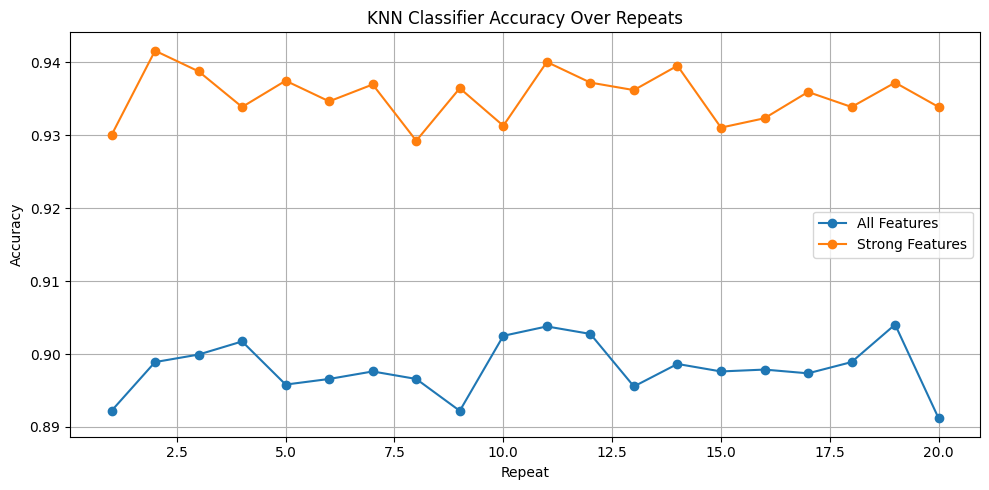


📋 Accuracy Evaluation Table:
   Percentage Repetition  Accuracy (All Features)  Accuracy (Modified  KNN)
0         10%        n=1                 0.895820                  0.931190
1         10%        n=2                 0.897106                  0.945338
2         10%        n=3                 0.909325                  0.940836
3         10%        n=4                 0.901608                  0.939550
4         10%        n=5                 0.884244                  0.925402
..        ...        ...                      ...                       ...
95        25%       n=16                 0.907641                  0.941343
96        25%       n=17                 0.896836                  0.944173
97        25%       n=18                 0.900180                  0.939542
98        25%       n=19                 0.894520                  0.935940
99        25%       n=20                 0.895549                  0.939028

[100 rows x 4 columns]


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)

# بارگذاری فایل
# Hill-Valley with Noise
# تشخیص سیگنال بالا یا پایین

import openml
import pandas as pd

dataset = openml.datasets.get_dataset(1046)
data, y_data, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# 🔧 افزودن target به dataframe کامل (مثل خواندن فایل CSV)
data['rating'] = y_data  # فرض می‌گیریم نام ستون هدف "rating" باشه برای یکسان بودن با مثال شما

print(data.shape)
# حذف سطرهای حاوی NaN
data = data.dropna()

# 🔍 نمایش اطلاعات
print(data.columns)
print(data.head())
print(data.shape)

# 🎯 جدا کردن ویژگی‌ها و برچسب‌ها (مطابق ساختار شما)
X_data = data.drop('rating', axis=1)
y_data = data['rating']
data_features = X_data.columns



# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, data_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)

# [5] Group features based on accuracy thresholds
strong_features = feature_scores[feature_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.83]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.78]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.67]['Feature'].tolist()


# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [list(data_features), strong_features, medium_features_1, medium_features_2, medium_features_3]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['all_features', 'strong_features', 'medium_features_1', 'medium_features_2', 'medium_features_3'],
    'Accuracy': acc_scores})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)

# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, strong_features,  all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "strong_features": []

    }

    feature_groups = {
        "all_features": data_features,
        "strong_features": strong_features
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(10, 5))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, strong_features, data_features, test_size=0.25, n_repeats=20)



def build_accuracy_table(X_data, y_data, strong_features, data_features, test_sizes, n_repeats):
    results = []

    for test_size in test_sizes:
        for i in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

            # KNN for all features
            k_all = int(np.sqrt(len(X_train)))
            knn_all = KNeighborsClassifier(n_neighbors=k_all)
            knn_all.fit(X_train[data_features], y_train)
            y_pred_all = knn_all.predict(X_test[data_features])
            acc_all = accuracy_score(y_test, y_pred_all)

            # KNN for medium features
            k_modified = int(np.sqrt(len(X_train)))
            knn_modified  = KNeighborsClassifier(n_neighbors=k_modified )
            knn_modified .fit(X_train[strong_features], y_train)
            y_pred_modified  = knn_modified .predict(X_test[strong_features])
            acc_modified  = accuracy_score(y_test, y_pred_modified )

            results.append({
                "Percentage": f"{int(test_size * 100)}%",
                "Repetition": f"n={i}",
                "Accuracy (All Features)": acc_all,
                "Accuracy (Modified  KNN)": acc_modified
            })

    df_result = pd.DataFrame(results)
    return df_result

test_sizes = [0.10 , 0.13, 0.16 , 0.19 , 0.25]  # یا چند درصد دیگر مثل [0.10, 0.15, 0.25]
n_repeats = 20

accuracy_table = build_accuracy_table(X_data, y_data, strong_features, data_features, test_sizes, n_repeats)
print("\n📋 Accuracy Evaluation Table:")
print(accuracy_table)


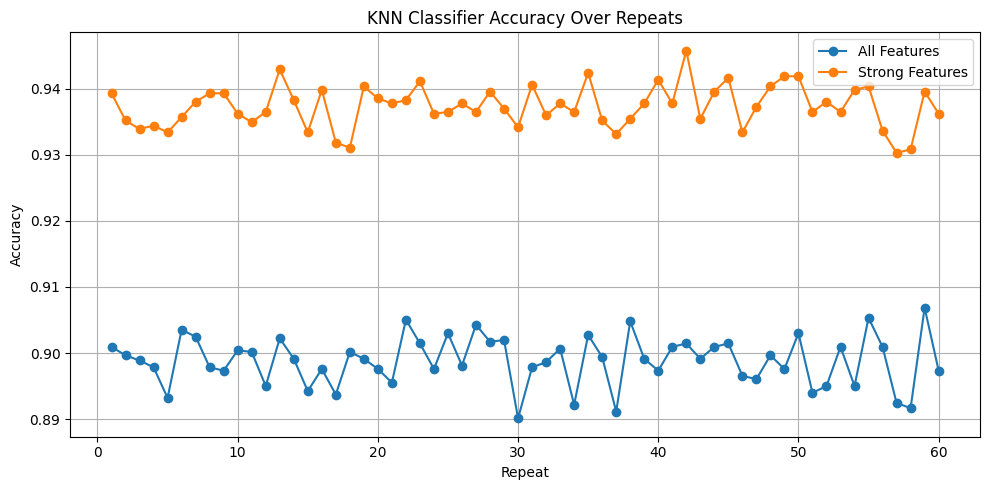

In [ ]:
evaluate_knn_accuracy_by_groups(X_data, y_data, strong_features, data_features, test_size=0.25, n_repeats=60)
